In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from flifile import FliFile
import glob
import os
import skimage
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
import timeit
from skimage.measure import LineModelND, ransac
import math
from sklearn.linear_model import RANSACRegressor, LinearRegression

In [264]:
fli = r'/home/preetham/Desktop/Project/Animations/50msEx3msGate_TRiCAM_4108628449.fli'

In [266]:
myflifile = FliFile(fli)
data = myflifile.getdata()
#data = np.array(data, dtype = float)
#counts_s,bins_s=np.histogram(data)#, range=(0,50));
#plt.hist(data, histtype = 'step')
print(type(data), np.shape(data)) 
#print(np.unravel_index(np.argmax(data), data.shape))
#print(data[1297,928])
print(np.mean(data))

<class 'numpy.ndarray'> (1920, 1200, 100)
2.677759986979167


In [267]:
#dfs = [pd.DataFrame(data[:,:,i]) for i in range(data.shape[2])]

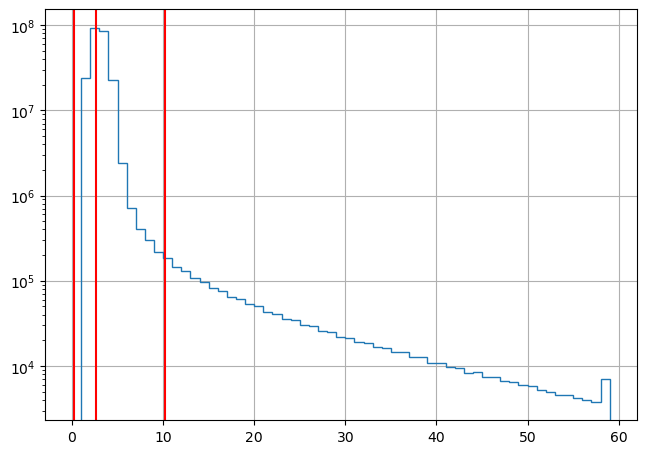

In [268]:
data = np.array(data, dtype = float)
plt.hist(data.flatten(), bins=np.arange(0, 60), histtype='step')
#plt.xticks(np.arange(0, 200, 1))  # set x-axis ticks at each integer
plt.axvline(np.mean(data), color = 'r')
plt.axvline(np.mean(data) + 3*np.std(data), color = 'r')
plt.axvline(np.mean(data) - np.std(data), color = 'r')
plt.grid(True)
plt.tight_layout()
plt.yscale('log')
plt.show()

So this is the picture. Anything below mean+3*std deviation, we speculate that it is heavily effected by noise, so we ignore it. Now probably just to get the idea of what it looks like we'll calculate that for each image in this fli file and plot one of them randomly.

(1920, 1200, 100)


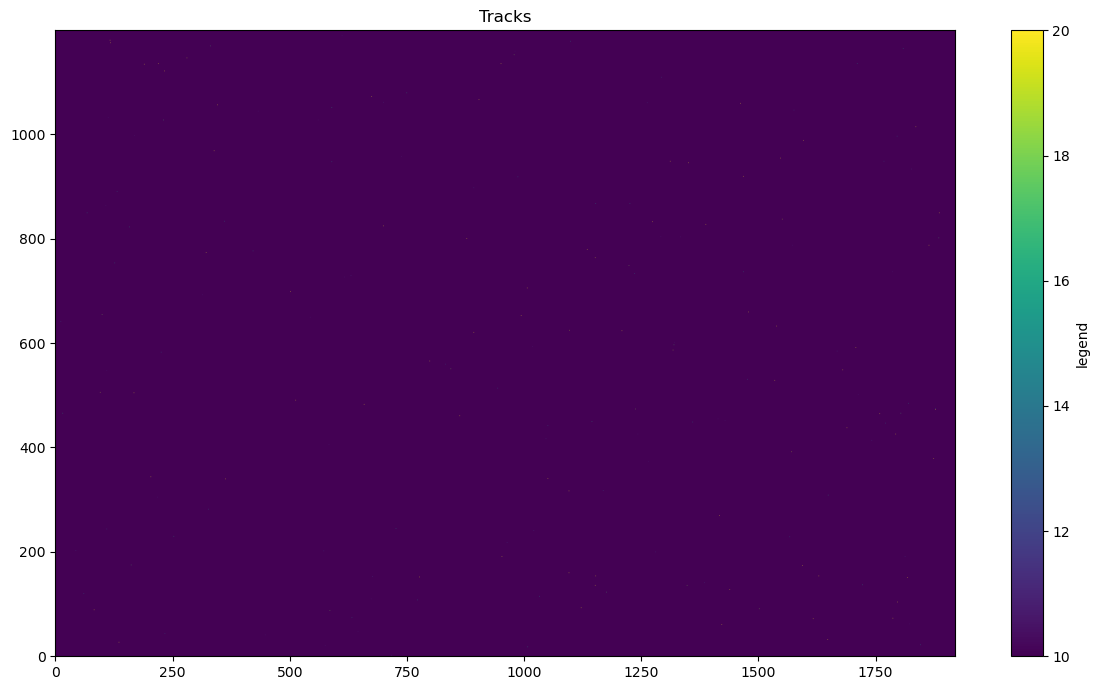

In [269]:
data_clear = np.where(data<10, 0, data)
plt.figure(figsize=(12,7))
im = plt.imshow(data_clear[: , : , 23].T, cmap = 'viridis', origin = 'lower', aspect = 'auto',vmin=10, vmax = 20)
plt.colorbar(im,label = 'legend')
plt.title('Tracks')
plt.tight_layout()
print(data_clear.shape)

In [270]:
I_track = np.sum(data_clear[975:1175, 200:800, :])/100
I_back = np.sum(data_clear[675:875, 200:800,:])/100
I_dark = np.sum(data_clear[100:300, 200:800,:])/100
print(I_track, I_back, I_dark)

77832.89 12928.34 9672.6


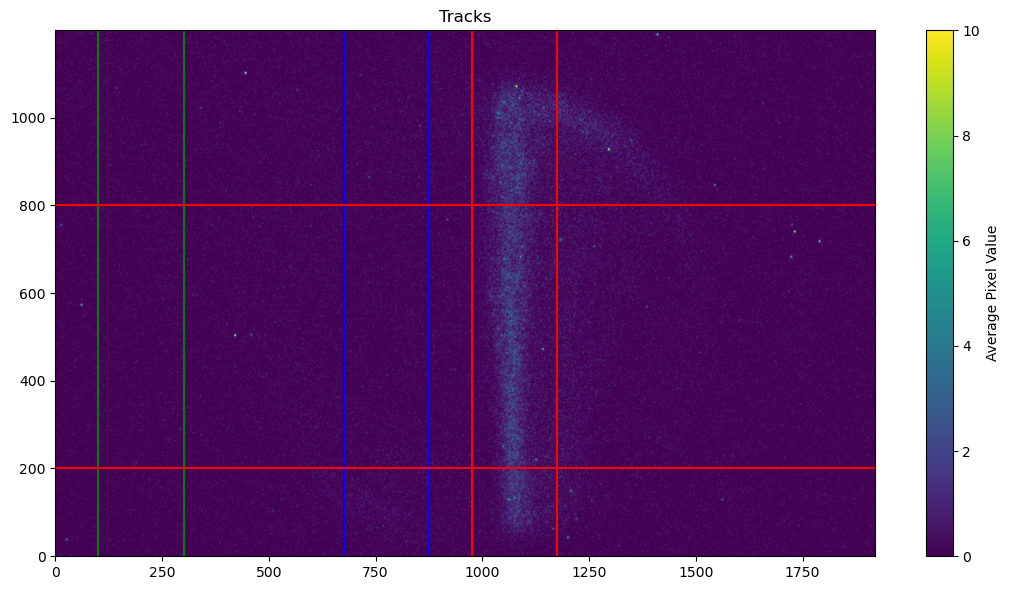

<Figure size 640x480 with 0 Axes>

In [271]:
avg_data = np.mean(data_clear, axis =2) #so this will average DU value (i think its called that) at each pixel
#lets do some plotting
plt.figure(figsize=(11,6))
im = plt.imshow(avg_data.T, cmap='viridis', origin='lower', aspect='auto', vmin=0, vmax=10) #C-P job this
plt.colorbar(im, label='Average Pixel Value')
plt.axvline(975, color = 'r')
plt.axvline(1175,color='r')
plt.axvline(675, color = 'b')
plt.axvline(875,color = 'b')
plt.axvline(100, color='g')
plt.axvline(300, color = 'g')
plt.axhline(200, color = 'r')
plt.axhline(800, color = 'r')
plt.title('Tracks')
plt.tight_layout()
plt.show()
plt.savefig('Layout of the areas chosen.png')

Now Let us make a function and returns all the value of our moderated function

['/home/preetham/Desktop/Project/Animations/50msEx100musGate_TRiCAM_4108628449.fli', '/home/preetham/Desktop/Project/Animations/50msEx10musGate_TRiCAM_4108628449.fli', '/home/preetham/Desktop/Project/Animations/50msEx1msGate_TRiCAM_4108628449.fli', '/home/preetham/Desktop/Project/Animations/50msEx200musGate_TRiCAM_4108628449.fli', '/home/preetham/Desktop/Project/Animations/50msEx20musGate_TRiCAM_4108628449.fli', '/home/preetham/Desktop/Project/Animations/50msEx3msGate_TRiCAM_4108628449.fli', '/home/preetham/Desktop/Project/Animations/50msEx500musGate_TRiCAM_4108628449.fli', '/home/preetham/Desktop/Project/Animations/50msEx50musGate_TRiCAM_4108628449.fli', '/home/preetham/Desktop/Project/Animations/50msEx5msGate_TRiCAM_4108628449.fli', '/home/preetham/Desktop/Project/Animations/50msEx5musGate_TRiCAM_4108628449.fli']


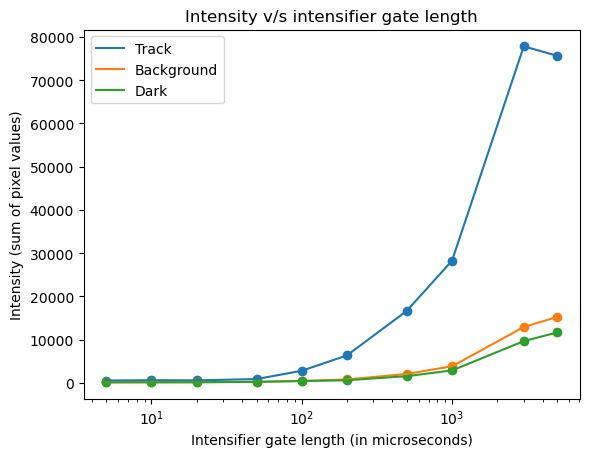

In [272]:
datafolder = r'/home/preetham/Desktop/Project/Animations'
fli_files = sorted(glob.glob(os.path.join(datafolder, "*.fli")))
def intensity_finder(file_path):
    myflifile = FliFile(file_path)
    data = myflifile.getdata()
    data = np.array(data, dtype = float)
    data_clear = np.where(data<10, 0, data)
    I_track = np.sum(data_clear[975:1175, 200:800, :])/100
    I_back = np.sum(data_clear[675:875, 200:800,:])/100
    I_dark = np.sum(data_clear[100:300, 200:800,:])/100
    return I_track, I_back, I_dark
print(fli_files)
I_track = []
I_back = []
I_dark = []
for fli in fli_files:
    x, y, z = intensity_finder(fli)
    I_track.append(x)
    I_back.append(y)
    I_dark.append(z)
x_axis = np.array([100,10,1000,200,20,3000,500,50,5000,5])
sorted_indices = np.argsort(x_axis)
x_axis = x_axis[sorted_indices]
#print(I_track, I_back, I_dark)
plt.plot(x_axis, np.array(I_track)[sorted_indices], label='Track')
plt.plot(x_axis, np.array(I_back)[sorted_indices], label='Background')
plt.plot(x_axis, np.array(I_dark)[sorted_indices], label='Dark')
plt.scatter(x_axis, np.array(I_track)[sorted_indices])
plt.scatter(x_axis, np.array(I_back)[sorted_indices])
plt.scatter(x_axis, np.array(I_dark)[sorted_indices])
plt.xlabel('Intensifier gate length (in microseconds)')
plt.ylabel('Intensity (sum of pixel values)')
plt.title('Intensity v/s intensifier gate length')
plt.xscale('log')
plt.legend()
plt.savefig('10 being the cutoff.png')

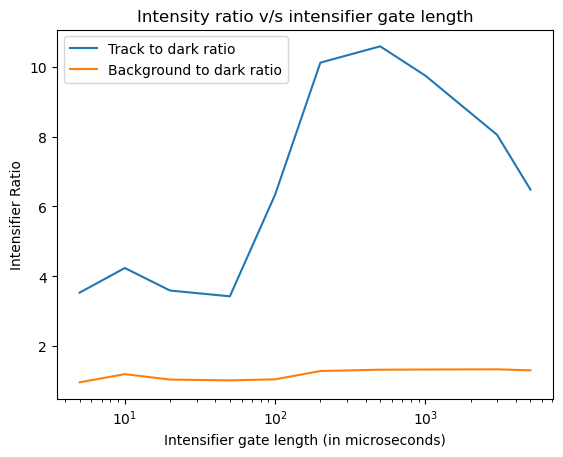

In [273]:
plt.plot(x_axis, (np.array(I_track)[sorted_indices]/(np.array(I_dark)[sorted_indices])), label='Track to dark ratio')
plt.plot(x_axis, (np.array(I_back)[sorted_indices]/(np.array(I_dark)[sorted_indices])), label='Background to dark ratio')
plt.xlabel('Intensifier gate length (in microseconds)')
plt.ylabel('Intensifier Ratio')
plt.title('Intensity ratio v/s intensifier gate length')
plt.xscale('log')
plt.legend()
#plt.savefig('10 being the cutoff.png')

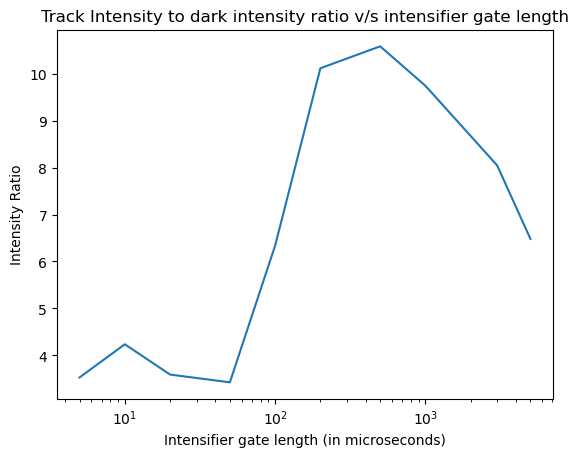

In [274]:
plt.plot(x_axis, (np.array(I_track)[sorted_indices]/(np.array(I_dark)[sorted_indices])))
plt.xlabel('Intensifier gate length (in microseconds)')
plt.ylabel('Intensity Ratio')
plt.title('Track Intensity to dark intensity ratio v/s intensifier gate length')
plt.xscale('log')
plt.savefig('Track intensity ratio.png')

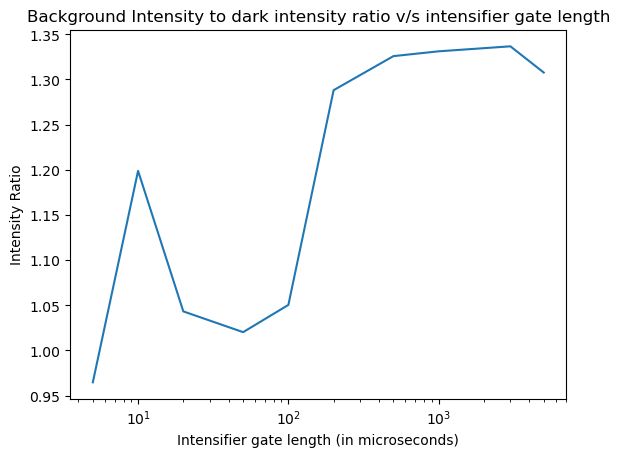

In [275]:
plt.plot(x_axis, (np.array(I_back)[sorted_indices]/(np.array(I_dark)[sorted_indices])))
plt.xlabel('Intensifier gate length (in microseconds)')
plt.ylabel('Intensity Ratio')
plt.title('Background Intensity to dark intensity ratio v/s intensifier gate length')
plt.xscale('log')
plt.savefig('Background intensity ratio.png')

58
(1920, 1200, 100)
(99,)


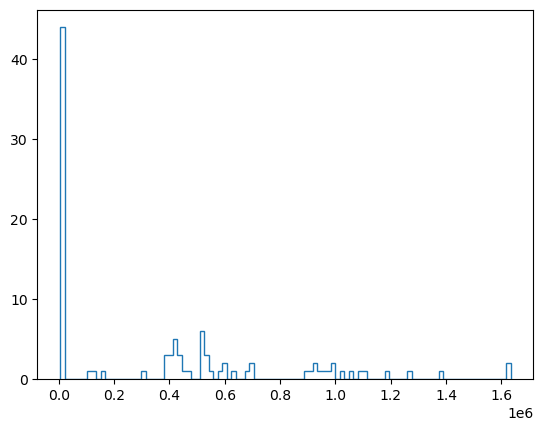

In [276]:
clean_x = np.arange(0,99,1)
clean_y = np.array([(np.sum(data_clear[:,:,i])) for i in range(0,99)])
plt.hist(clean_y,bins = 100, histtype = 'step')
print(np.argmax(clean_y))
print(data_clear.shape)
print(clean_y.shape)

So, that is quite nice think I can just filter the near zero ones cause they, evidently don't have an avalanche event

11
1838.0
1799.0
(1920, 1200, 55)


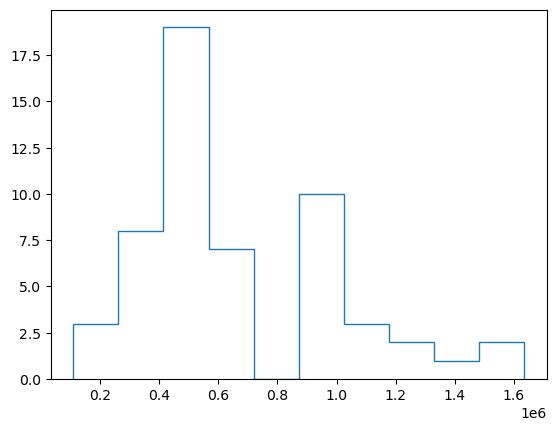

In [277]:
filter_y = np.argwhere(clean_y>100000).flatten()
#print(filter_x)
avl_data = np.array([data_clear[:,:,i] for i in filter_y])
avl_data = avl_data.transpose(1,2,0)
plt.hist(clean_y[filter_y], histtype ='step');
print(np.argmin(clean_y[filter_y]))
print(np.max(avl_data))
print(np.max(avl_data[:,:,26]))
print(avl_data.shape)
avl_data_sum = np.sum(avl_data, axis=2)

For now, I'll work with data_clear I guess, we'll see how to do it to everything without using a lot of computational power later.

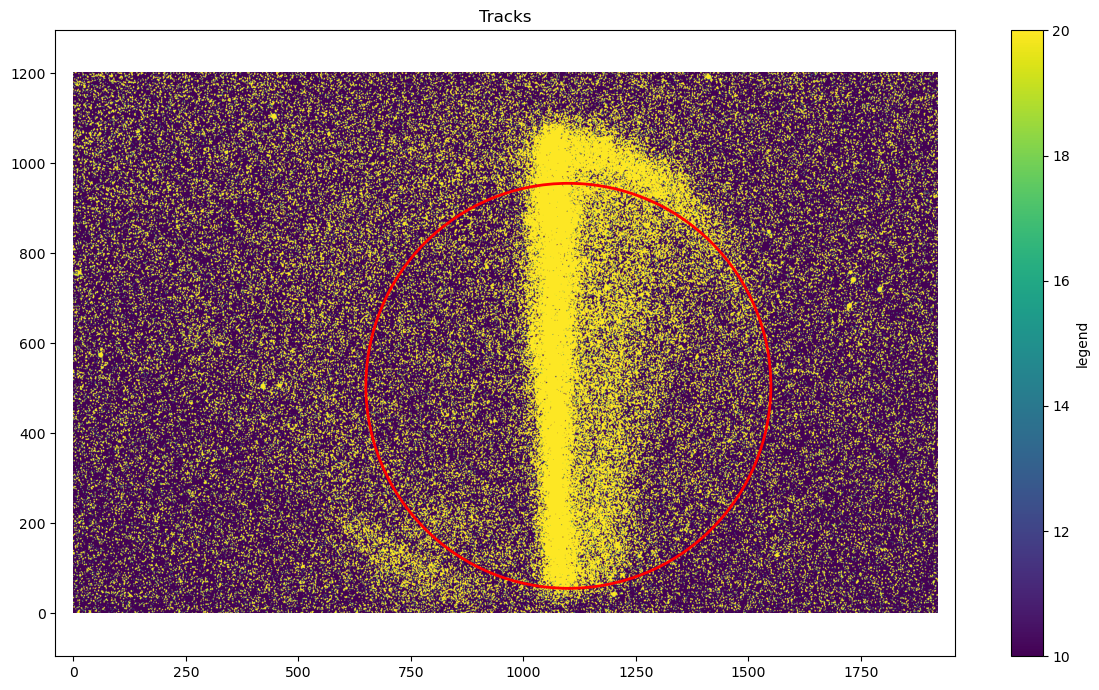

In [278]:
image = avl_data_sum.T
center_x, center_y, radius = 1100, 505, 450
plt.figure(figsize=(12,7))
im = plt.imshow(image, cmap='viridis', origin='lower', aspect='auto', vmin=10, vmax=20)
plt.colorbar(im, label='legend')
ax = plt.gca()
circ = plt.Circle((center_x, center_y), radius, color='red', fill=False, lw=2)
ax.add_patch(circ)
plt.axis('equal')
plt.title('Tracks')
plt.tight_layout()
plt.show()
orig_image = avl_data[:,:,26].T



So, we manually decide what the circle is no funny business with canny edge or whatever

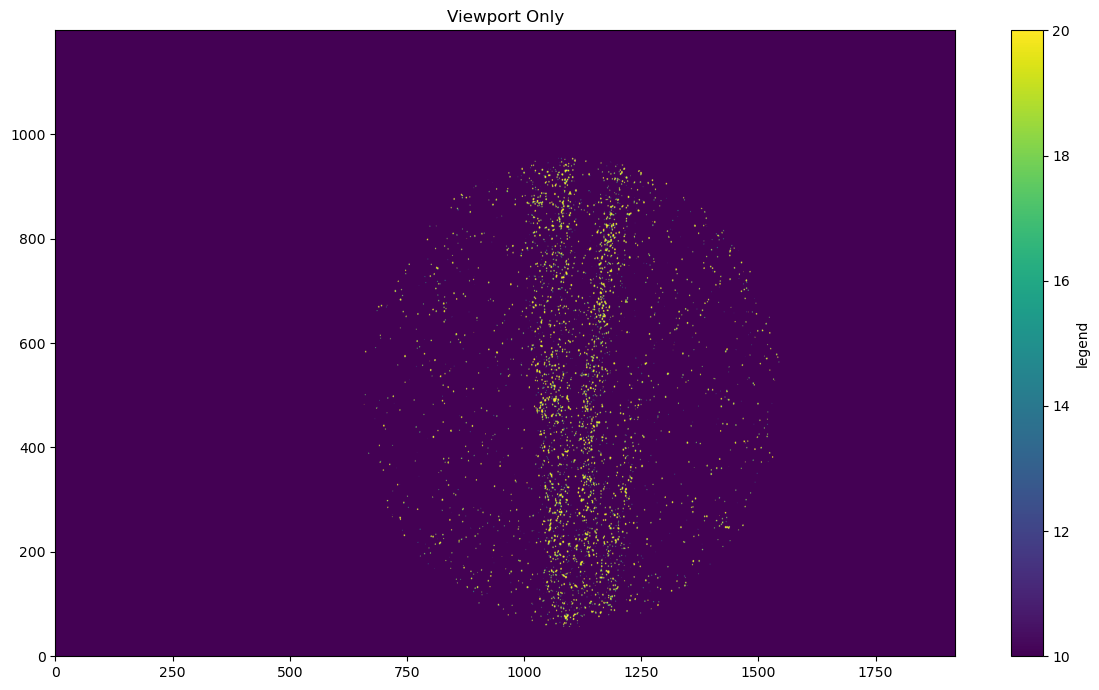

In [306]:
orig_image = avl_data[:,:,47].T
masked_image = np.zeros_like(orig_image)

# Create circular mask
Y, X = np.ogrid[:orig_image.shape[0], :orig_image.shape[1]]
dist_from_center = np.sqrt((X - center_x)**2 + (Y - center_y)**2)
mask = dist_from_center <= radius

# Apply mask
masked_image[mask] = orig_image[mask]

# Plot to check
plt.figure(figsize=(12, 7))
plt.imshow(masked_image, cmap='viridis', origin='lower', aspect='auto', vmin=10, vmax=20)
plt.colorbar(label='legend')
plt.title('Viewport Only')
plt.tight_layout()
plt.show()

Now, we start the actual analysis. For DBSCAN and RANSAC, we need a binary image - thats where we'll begin for now.

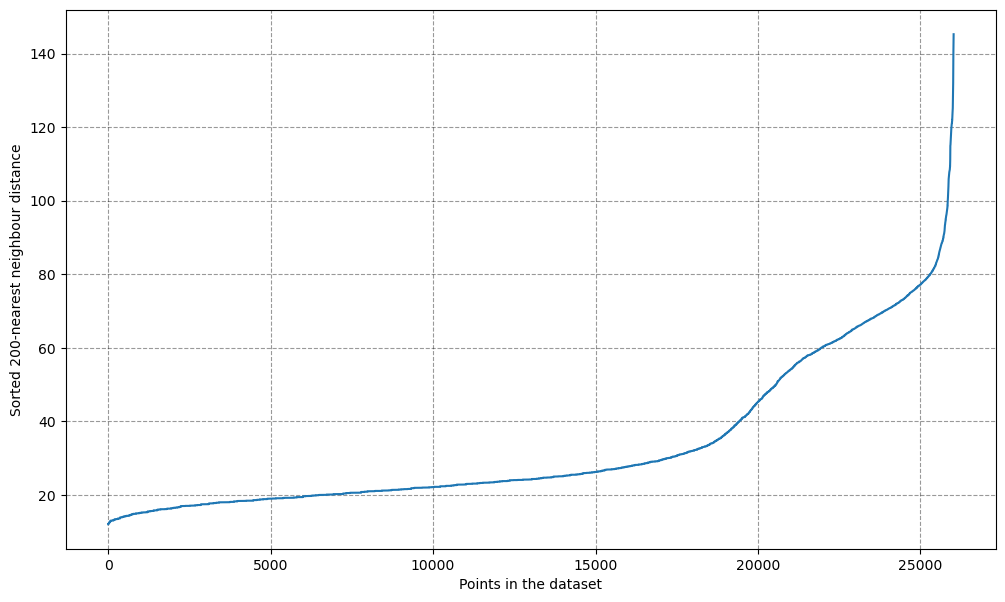

In [307]:
#Binarise image
binary_image = np.where(masked_image>0,1,0)

#Make coordinates
coords = np.nonzero(binary_image)
coords_array = np.column_stack(coords)

#Get the k-distance plot
def get_kdist_plot(X=None, k=None, radius_nbrs=1.0):
    nbrs = NearestNeighbors(n_neighbors=k, radius=radius_nbrs).fit(X)
    distances, indices = nbrs.kneighbors(X) #Calculates the distance for each point
    distances = np.sort(distances, axis=0)
    distances = distances[:, k-1]
    distances= distances
    fig=plt.figure(figsize=(12,7))#figsize=(8,8))
    plt.plot(distances)
    plt.xlabel('Points in the dataset')
    plt.ylabel('Sorted {}-nearest neighbour distance'.format(k))
    plt.grid(True, linestyle="--", color='black', alpha=0.4)
    plt.show()
get_kdist_plot(X=coords_array, k=200)

Ok, that looks kinda ugly! Maybe arond 50 is the answer? Katies thesis was definitley 20, lets see...

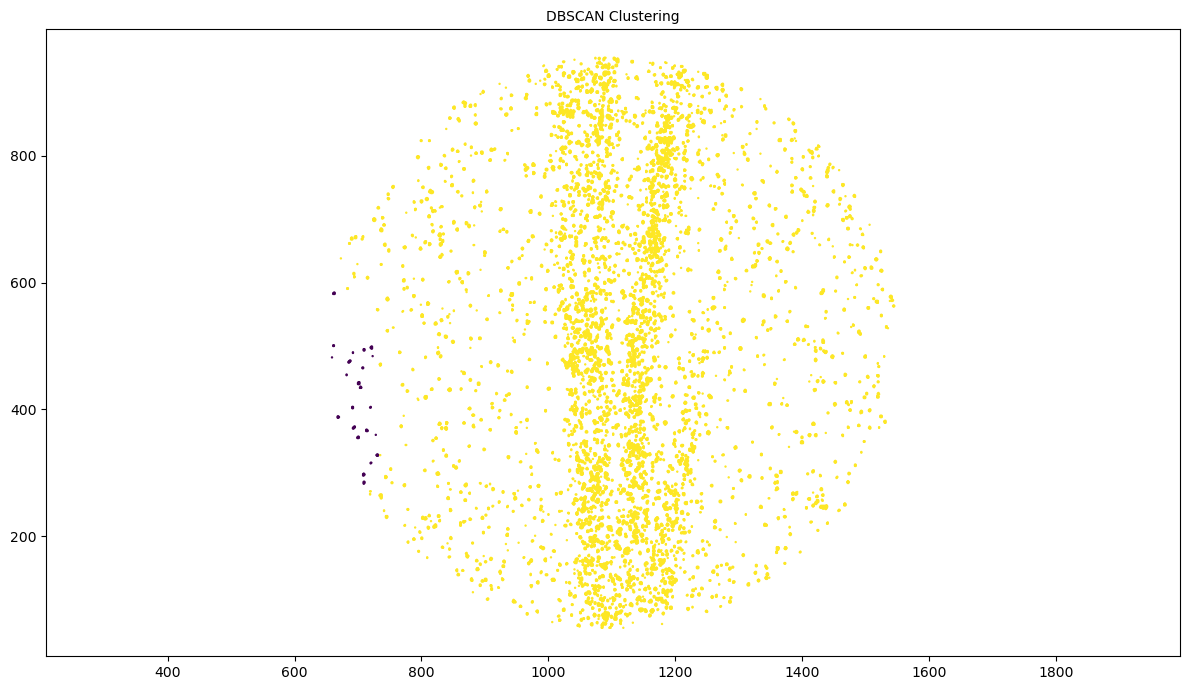

(25889, 2)


In [308]:
#DBSCAN CLUSTERING
cluster_size_array = np.zeros(4200)
count = 0
#time_start_dbscan = timeit.default_timer
db_eps = 75
db_min_samp = 200
dbscan  = DBSCAN(eps = db_eps, min_samples = db_min_samp)
dbscan.fit(coords_array)
labels = dbscan.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
if n_clusters_>0:
    clusters = [coords_array[labels == i] for i in range(n_clusters_)]
    clusters_size=[len(clusters[i]) for i in range(n_clusters_)]
    all_clusters= coords_array[labels!= -1]
    max_cluster=np.max(clusters_size) #how big is largest cluster
    cluster_size_array[count+1]=max_cluster
    ind=np.array(clusters[np.argmax(clusters_size)])  #indices of points in largest cluster
    if max_cluster > 1200:   #Threshold for track
        cluster_image = np.zeros_like(orig_image)
        fig=plt.figure(figsize=(12,7))
        plt.scatter(coords_array[:,1],coords_array[:,0],c=labels,s=0.5)
        plt.title('DBSCAN Clustering',fontsize=10)
        plt.xlim([0,1920])
        plt.ylim([0,1200])
        plt.axis('equal')
        plt.tight_layout()
        plt.show()
print(np.shape(ind))

In [299]:
#RANSAC BEGINS
model_robust, inliers = ransac(ind, LineModelND, min_samples=10, residual_threshold=43, max_trials=1000)
outliers = inliers == False
fig=plt.figure(figsize=(12,7))
plt.plot(ind[inliers, 1], ind[inliers, 0], '.b', alpha=0.6, label='Inlier data')
plt.plot(ind[outliers, 1], ind[outliers, 0], '.r', alpha=0.6, label='Outlier data')
plt.legend(loc='lower left')
plt.axis("equal")
plt.title('RANSAC')
plt.tight_layout()

TypeError: 'RANSACRegressor' object is not callable

That looks ok - I dont know why the k distance plot and the d_eps dont agree neatly. Lets just plot the track then

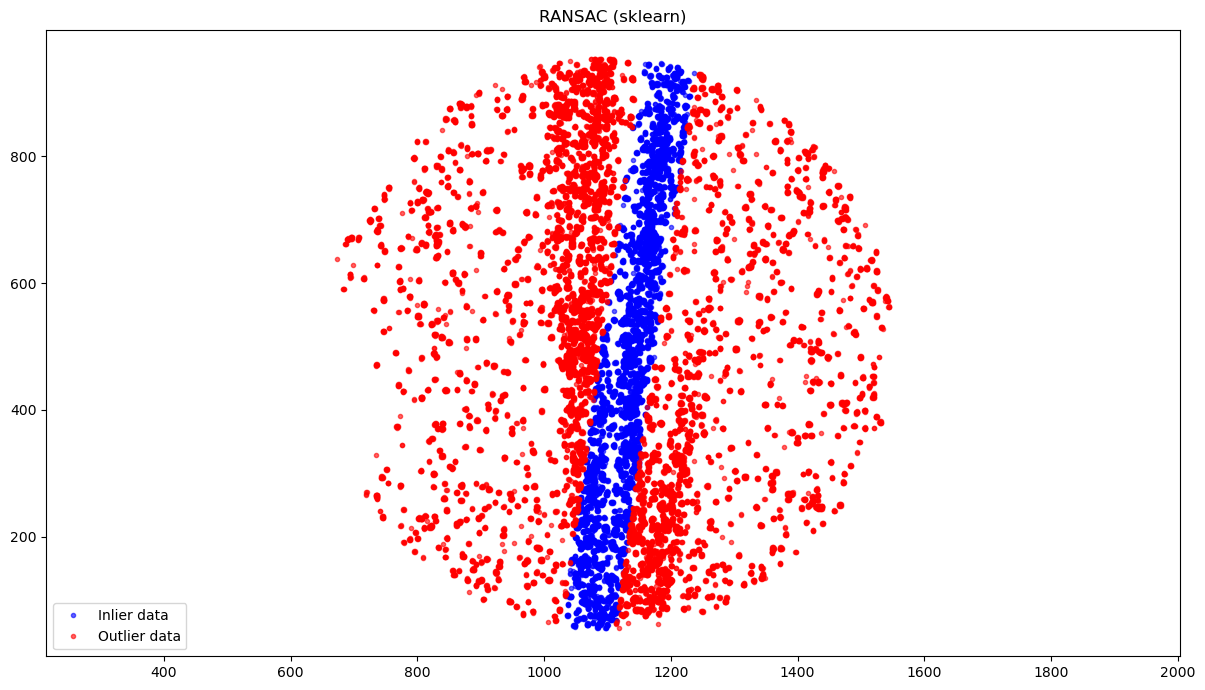

In [319]:
X = ind[:, 0].reshape(-1, 1)  # Feature: column index 1
y = ind[:, 1]                 # Target: column index 0

# Define RANSACRegressor with same parameters
ransac = RANSACRegressor(
    estimator=LinearRegression(),
    min_samples=10,
    residual_threshold=43,
    max_trials=1000,
    stop_score = 0.95
)

# Fit it
ransac.fit(X, y)

# Get inlier mask
inliers = ransac.inlier_mask_
outliers = ~inliers  # Logical NOT

# Plot same way
plt.figure(figsize=(12, 7))
plt.plot(y[inliers], X[inliers], '.b', alpha=0.6, label='Inlier data')
plt.plot(y[outliers], X[outliers], '.r', alpha=0.6, label='Outlier data')
plt.legend(loc='lower left')
plt.axis("equal")
plt.title('RANSAC (sklearn)')
plt.tight_layout()
plt.show()

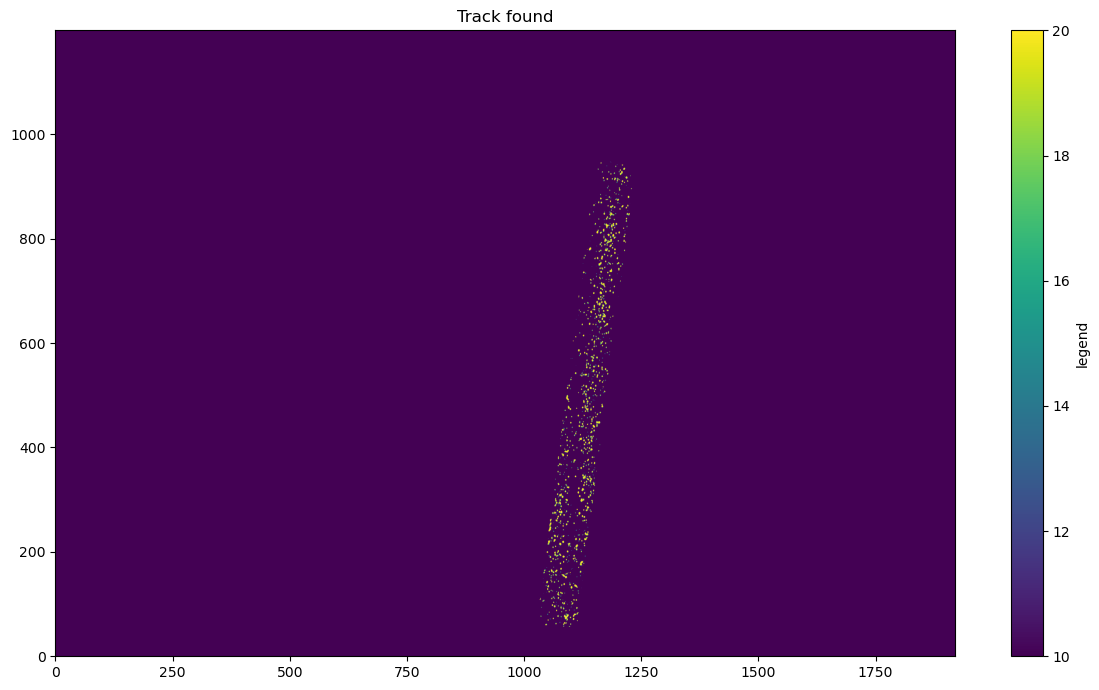

In [320]:
cluster_mask = np.zeros_like(orig_image)
x = ind[inliers,0]
y = ind[inliers,1]
for i in range(len(x)):
    x_i = x[i]
    y_i = y[i]
    cluster_mask[x_i,y_i] = 1
Track = masked_image*cluster_mask
plt.figure(figsize=(12, 7))
plt.imshow(Track, cmap='viridis', origin='lower', aspect='auto', vmin=10, vmax=20)
plt.colorbar(label='legend')
plt.title('Track found')
plt.tight_layout()
plt.show()

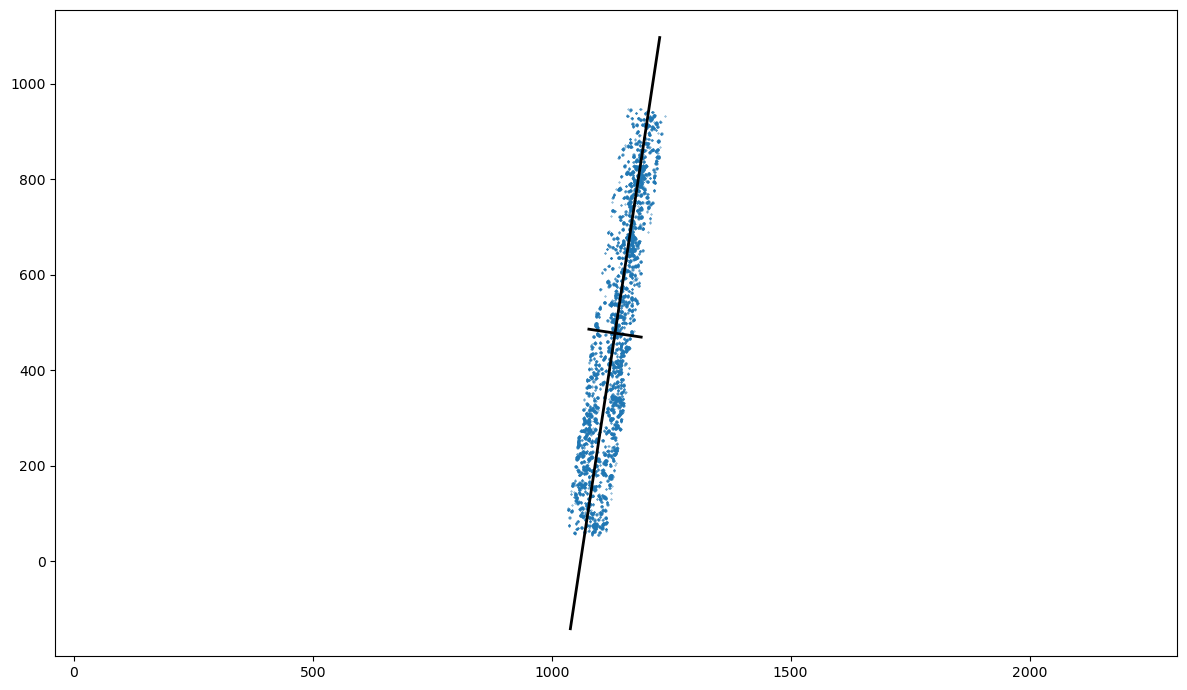

In [321]:
#PCA FROM HERE
X = np.column_stack((x,y))
pca = PCA(n_components=2)
pca.fit(X)
fig=plt.figure(figsize=(12,7))
plt.scatter(X[:, 1], X[:, 0], s=0.1)
plt.axis('equal')
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 2.5 *np.sqrt(length)
    start_point=pca.mean_-v
    end_point=pca.mean_+v
    plt.plot([start_point[1],end_point[1]],[start_point[0],end_point[0]],linewidth=2,color='k')
plt.tight_layout()

Ok, Thats quite nice I think, Now just calculate the track length, track angle and stuff

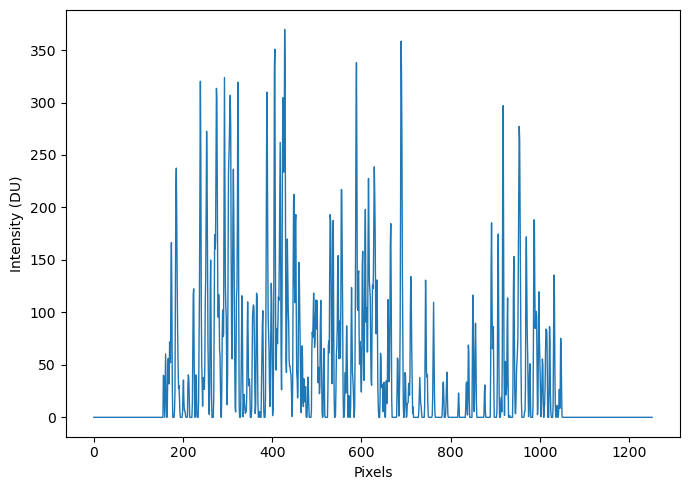

In [322]:
#Building Component 1
length=pca.explained_variance_[0]
vector=pca.components_[0]
v = vector * np.sqrt(length)

mean=pca.mean_
end_midpoint=mean + 0.5*v
start_midpoint=mean - 0.5*v
end_point=mean + 1*v
start_point=mean - 1*v
pca1_start_point= mean - 2.5*v
pca1_end_point= mean + 2.5*v

length_v_pca1=int(np.linalg.norm(v))

width_of_line=15
profile_pc1 = skimage.measure.profile_line(Track, pca1_end_point, pca1_start_point, linewidth=width_of_line, mode='constant',cval=0,reduce_func=np.sum)

fig=plt.figure(figsize=(7,5))
plt.plot(profile_pc1,linewidth=1)
plt.xlabel("Pixels")
plt.ylabel("Intensity (DU)")
plt.tight_layout()

In [323]:
#Building Component 2
length=pca.explained_variance_[1]
vector=pca.components_[1]
v = vector * 3 * np.sqrt(length)
cut1_start= start_point - v
cut1_end=start_point + v
cut2_start= start_midpoint - v
cut2_end=start_midpoint + v
cut3_start= mean - v
cut3_end=mean + v
cut4_start= end_midpoint - v
cut4_end=end_midpoint + v
cut5_start= end_point - v
cut5_end=end_point+ v
start=(cut3_start[0],cut3_end[0])
end= (cut3_start[1],cut3_end[1])
profile_pc2 = skimage.measure.profile_line(Track, cut3_start, cut3_end, linewidth=100, mode='constant',cval=0,reduce_func=np.sum)
#I dont know where this is used 

In [288]:
#Track length
non_zero_elements=np.where(profile_pc1>0)
first_non_zero_index=non_zero_elements[0][0]
last_non_zero_index=non_zero_elements[0][-1]
track_length_pixels =last_non_zero_index-first_non_zero_index
track_length=track_length_pixels
print("Track length (in number of pixels as of yet):", track_length)

Track length (in number of pixels as of yet): 895


In [324]:
#Direction of Track
direction_vector=pca.components_[0]
#Clockwise from zero at source is negative, Anticlockwise is positive
angle=-(90-math.degrees(math.atan(direction_vector[0]/direction_vector[1])))
if np.abs(angle) >90 :
    angle=180 + angle 
print("Direction of track=",angle, "degrees")

Direction of track= -8.592964077488915 degrees


I guess now is the time to do some analysis on the entire image list thingy.
Slight complication - even in images with track - the intensity is not uniform enough that it runs on a single dbscan setting - maybe i can guage it with the length of the track (why?)

In [325]:
track_length_set = np.array([])
angle_track_set = np.array([])
for i in range(0,55):
    orig_image = avl_data[:,:,i].T
    masked_image = np.zeros_like(orig_image)

    # Create circular mask
    Y, X = np.ogrid[:orig_image.shape[0], :orig_image.shape[1]]
    dist_from_center = np.sqrt((X - center_x)**2 + (Y - center_y)**2)
    mask = dist_from_center <= radius

    # Apply mask
    masked_image[mask] = orig_image[mask]
    
    #Binarise image
    binary_image = np.where(masked_image>0,1,0)

    #Make coordinates
    coords = np.nonzero(binary_image)
    coords_array = np.column_stack(coords)

    #DBSCAN CLUSTERING
    cluster_size_array = np.zeros(4200)
    count = 0
    for j in range(20,80,5):
        for k in range(50,200,10):
            db_eps = j
            db_min_samp = k
            dbscan  = DBSCAN(eps = db_eps, min_samples = db_min_samp)
            dbscan.fit(coords_array)
            labels = dbscan.labels_
            n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
            n_noise_ = list(labels).count(-1)
            if n_clusters_>0:
                clusters = [coords_array[labels == i] for i in range(n_clusters_)]
                clusters_size=[len(clusters[i]) for i in range(n_clusters_)]
                all_clusters= coords_array[labels!= -1]
                max_cluster=np.max(clusters_size) #how big is largest cluster
                cluster_size_array[count+1]=max_cluster
                ind=np.array(clusters[np.argmax(clusters_size)])  #indices of points in largest cluster
            X = ind[:, 0].reshape(-1, 1)  # Feature: column index 1
            y = ind[:, 1]                 # Target: column index 0

            # Define RANSACRegressor with same parameters
            ransac = RANSACRegressor(
                estimator=LinearRegression(),
                min_samples=10,
                residual_threshold=43,
                max_trials=1000,
                stop_score = 0.95
            )

            # Fit it
            ransac.fit(X, y)

            # Get inlier mask
            inliers = ransac.inlier_mask_
            outliers = ~inliers  # Logical NOT

            #Cluster_mask in case you want to plot in future
            cluster_mask = np.zeros_like(orig_image)
            x = ind[inliers,0]
            y = ind[inliers,1]
            for i in range(len(x)):
                x_i = x[i]
                y_i = y[i]
                cluster_mask[x_i,y_i] = 1
            Track = masked_image*cluster_mask

            #PCA From here
            X = np.column_stack((x,y))
            pca = PCA(n_components=2)
            pca.fit(X)
            for length, vector in zip(pca.explained_variance_, pca.components_):
                v = vector * 2.5 *np.sqrt(length)
                start_point=pca.mean_-v
                end_point=pca.mean_+v
            
            #Building Component 1
            length=pca.explained_variance_[0]
            vector=pca.components_[0]
            v = vector * np.sqrt(length)
            
            mean=pca.mean_
            end_midpoint=mean + 0.5*v
            start_midpoint=mean - 0.5*v
            end_point=mean + 1*v
            start_point=mean - 1*v
            pca1_start_point= mean - 2.5*v
            pca1_end_point= mean + 2.5*v
            
            length_v_pca1=int(np.linalg.norm(v))
            
            width_of_line=15
            profile_pc1 = skimage.measure.profile_line(Track, pca1_end_point, pca1_start_point, linewidth=width_of_line, mode='constant',cval=0,reduce_func=np.sum)

            #Building Component 2
            length=pca.explained_variance_[1]
            vector=pca.components_[1]
            v = vector * 3 * np.sqrt(length)
            cut1_start= start_point - v
            cut1_end=start_point + v
            cut2_start= start_midpoint - v
            cut2_end=start_midpoint + v
            cut3_start= mean - v
            cut3_end=mean + v
            cut4_start= end_midpoint - v
            cut4_end=end_midpoint + v
            cut5_start= end_point - v
            cut5_end=end_point+ v
            start=(cut3_start[0],cut3_end[0])
            end= (cut3_start[1],cut3_end[1])
            profile_pc2 = skimage.measure.profile_line(Track, cut3_start, cut3_end, linewidth=100, mode='constant',cval=0,reduce_func=np.sum)

            #Track length
            non_zero_elements=np.where(profile_pc1>0)
            first_non_zero_index=non_zero_elements[0][0]
            last_non_zero_index=non_zero_elements[0][-1]
            track_length_pixels =last_non_zero_index-first_non_zero_index
            track_length=track_length_pixels

            #Direction of Track
            direction_vector=pca.components_[0]
            #Clockwise from zero at source is negative, Anticlockwise is positive
            angle=-(90-math.degrees(math.atan(direction_vector[0]/direction_vector[1])))
            if np.abs(angle) >90 :
                angle=180 + angle 
            if track_length>800:
                should_break = True
                break
        if should_break:
            break
    track_length_set = np.append(track_length_set, track_length)
    angle_track_set = np.append(angle_track_set, angle)


36


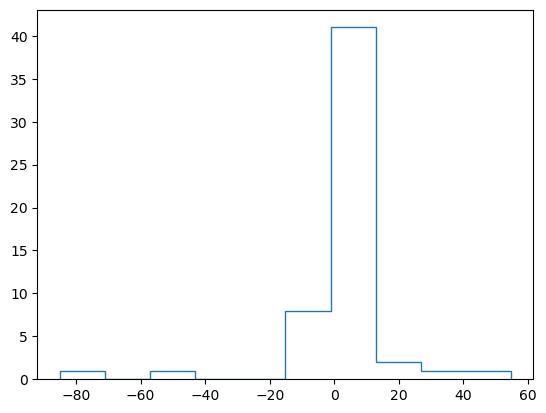

In [326]:
plt.hist(angle_track_set, histtype = 'step')
print(np.argmin(angle_track_set))

In [343]:
track_length_set_1 = np.array([])
angle_track_set_1 = np.array([])
energy_set_1 = np.array([])
sigma_set_1 = np.array([])

for i in range(0, 55):
    orig_image = avl_data[:, :, i].T
    masked_image = np.zeros_like(orig_image)

    # Create circular mask
    Y, X = np.ogrid[:orig_image.shape[0], :orig_image.shape[1]]
    dist_from_center = np.sqrt((X - center_x) ** 2 + (Y - center_y) ** 2)
    mask = dist_from_center <= radius

    # Apply mask
    masked_image[mask] = orig_image[mask]

    # Binarise image
    binary_image = np.where(masked_image > 0, 1, 0)

    # Make coordinates
    coords = np.nonzero(binary_image)
    coords_array = np.column_stack(coords)

    # DBSCAN CLUSTERING
    cluster_size_array = np.zeros(4200)
    count = 0
    db_eps = 75
    db_min_samp = 200
    dbscan = DBSCAN(eps=db_eps, min_samples=db_min_samp)
    dbscan.fit(coords_array)
    labels = dbscan.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    if n_clusters_ > 0:
        clusters = [coords_array[labels == i] for i in range(n_clusters_)]
        clusters_size = [len(clusters[i]) for i in range(n_clusters_)]
        all_clusters = coords_array[labels != -1]
        max_cluster = np.max(clusters_size)  # how big is largest cluster
        cluster_size_array[count + 1] = max_cluster
        ind = np.array(clusters[np.argmax(clusters_size)])  # indices of points in largest cluster

        X = ind[:, 0].reshape(-1, 1)  # Feature: column index 1
        y = ind[:, 1]                 # Target: column index 0

        # Define RANSACRegressor with same parameters
        ransac = RANSACRegressor(
            estimator=LinearRegression(),
            min_samples=10,
            residual_threshold=43,
            max_trials=1000,
            stop_score=0.95
        )

        # Fit it
        ransac.fit(X, y)

        # Get inlier mask
        inliers = ransac.inlier_mask_
        outliers = ~inliers  # Logical NOT

        # Cluster_mask in case you want to plot in future
        cluster_mask = np.zeros_like(orig_image)
        x = ind[inliers, 0]
        y = ind[inliers, 1]
        for i in range(len(x)):
            x_i = x[i]
            y_i = y[i]
            cluster_mask[x_i, y_i] = 1
        Track = masked_image * cluster_mask

        # PCA From here
        X = np.column_stack((x, y))
        pca = PCA(n_components=2)
        pca.fit(X)
        for length, vector in zip(pca.explained_variance_, pca.components_):
            v = vector * 2.5 * np.sqrt(length)
            start_point = pca.mean_ - v
            end_point = pca.mean_ + v

        # Building Component 1
        length = pca.explained_variance_[0]
        vector = pca.components_[0]
        v = vector * np.sqrt(length)

        mean = pca.mean_
        end_midpoint = mean + 0.5 * v
        start_midpoint = mean - 0.5 * v
        end_point = mean + 1 * v
        start_point = mean - 1 * v
        pca1_start_point = mean - 2.5 * v
        pca1_end_point = mean + 2.5 * v

        length_v_pca1 = int(np.linalg.norm(v))

        width_of_line = 15
        profile_pc1 = skimage.measure.profile_line(
            Track,
            pca1_end_point,
            pca1_start_point,
            linewidth=width_of_line,
            mode='constant',
            cval=0,
            reduce_func=np.sum
        )

        # Building Component 2
        length = pca.explained_variance_[1]
        vector = pca.components_[1]
        v = vector * 3 * np.sqrt(length)
        cut1_start = start_point - v
        cut1_end = start_point + v
        cut2_start = start_midpoint - v
        cut2_end = start_midpoint + v
        cut3_start = mean - v
        cut3_end = mean + v
        cut4_start = end_midpoint - v
        cut4_end = end_midpoint + v
        cut5_start = end_point - v
        cut5_end = end_point + v

        start = (cut3_start[0], cut3_end[0])
        end = (cut3_start[1], cut3_end[1])
        profile_pc2 = skimage.measure.profile_line(
            Track,
            cut3_start,
            cut3_end,
            linewidth=100,
            mode='constant',
            cval=0,
            reduce_func=np.sum
        )

        # Track length
        non_zero_elements = np.where(profile_pc1 > 0)
        first_non_zero_index = non_zero_elements[0][0]
        last_non_zero_index = non_zero_elements[0][-1]
        track_length_pixels = last_non_zero_index - first_non_zero_index
        track_length = track_length_pixels

        # Direction of Track
        direction_vector = pca.components_[0]
        # Clockwise from zero at source is negative, Anticlockwise is positive
        angle = -(90 - math.degrees(math.atan(direction_vector[0] / direction_vector[1])))
        if np.abs(angle) > 90:
            angle = 180 + angle

        track_length_set_1 = np.append(track_length_set_1, track_length)
        angle_track_set_1 = np.append(angle_track_set_1, angle)

        #Energy and dE/dx
        Energy = np.sum(Track)
        de_dx = Energy/track_length
        energy_set_1 = np.append(energy_set_1, de_dx)

        '''#Sigma
        # Define the Gaussian function function to fit
        def gaussian(x, a, mu, sigma):
            return a*np.exp(-(x-mu)**2/(2*sigma**2))
                        
        #define data
        xdata=np.linspace(1,len(profile_pc2),num=len(profile_pc2)) 
        ydata=profile_pc2
    
        # fit the data and plot the result
        try:
            param, cov = curve_fit(gaussian, xdata,ydata, p0=(300,sum(xdata*ydata/sum(ydata)),5))
        except:
            param = None
            covmat = None
        if not param is None:
            amp_gaus  = param[0] #amplitude 
            mean_gaus = param[1] #mean of gaussian dist
            std_gaus = abs(param[2]) #stdev of the dist
            sigma= std_gaus
        sigma_set_1 = np.append(sigma_set_1,sigma)'''


(array([ 5.,  5.,  5.,  5.,  9.,  6., 10.,  5.,  1.,  2.]),
 array([-2.01862963, -1.40182278, -0.78501592, -0.16820906,  0.4485978 ,
         1.06540466,  1.68221152,  2.29901837,  2.91582523,  3.53263209,
         4.14943895]),
 [<matplotlib.patches.Polygon at 0x70f7bfafb170>])

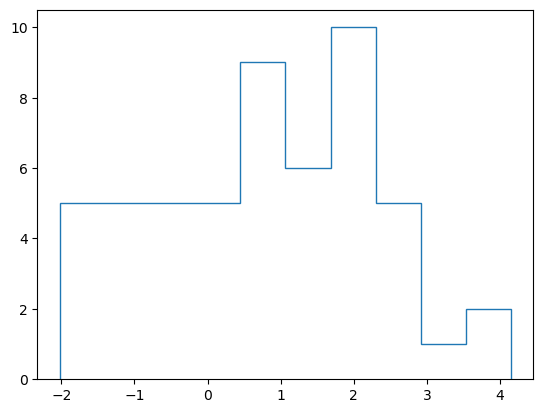

In [340]:
angle_track_set_1 = angle_track_set_1[angle_track_set_1 > -4]
plt.hist(angle_track_set_1, histtype = 'step')

(array([ 6., 18.,  9.,  6.,  8.,  4.,  1.,  0.,  1.,  2.]),
 array([ 43.74726776,  92.56175122, 141.37623467, 190.19071813,
        239.00520159, 287.81968505, 336.63416851, 385.44865196,
        434.26313542, 483.07761888, 531.89210234]),
 [<matplotlib.patches.Polygon at 0x70f7bfda52b0>])

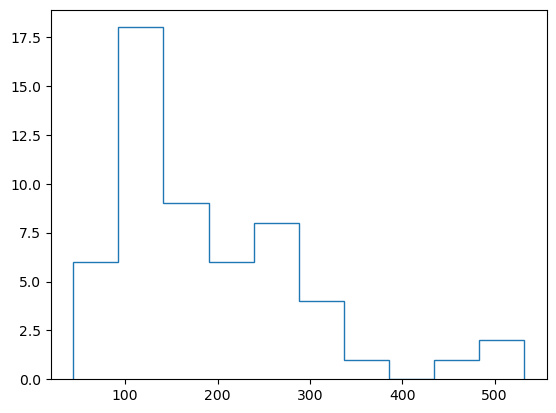

In [344]:
plt.hist(energy_set_1, histtype ='step')

In [ ]:
plt.hist(sigma_set_1, histtype = 'step')